In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as scs
import scipy.special as scl
import scipy.integrate as spint
import scipy.interpolate as spinterp
import scipy.fft as scft
import scipy.stats as scst

In [2]:
def purefringes(y_detector,parameters, delta_p=0, printvals = False):
    """
    This function calculates the fringe pattern for given parameters and detector y coordinates. 
    This function does not take into account the fresnel diffraction effect from the slats.
    """
     # baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength,
    # parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # y_0 is the central point of the fringes on the detector.
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    # Re-define coordinate system such that y_prime is 0 for the central fringe
    y_prime = y_detector - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return fringe_amp, fringe_spacing, y_0, y_prime

def fresnel_diff(y_detector, parameters, delta_p=0, printvals = False):
    """
    Calculates the fresnel diffraction pattern for given set of parameters
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    y_0 = -L * theta_offaxis
    y_prime = y_detector - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A = C_2 - C_1 + 1j*(S_2 - S_1)
    # plt.plot(np.abs(A)**2)
    # plt.show()
    

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return A, y_prime, y_0

In [3]:
def calc_single(y_val, parameters, delta_p=0):
    """
    Calculates the amplitude for a single given y-axis position.
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # Fringe Pattern
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    y_prime = y_val - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    A_fringe = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b
    
    
    # Fresnel Diffraction
    y_0 = -L * theta_offaxis
    y_prime = y_val - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A_fresnel = C_2 - C_1 + 1j*(S_2 - S_1)

    A_full = A_fresnel * A_fringe
    return A_full

In [4]:
def GenerateSamples(sample_size,parameters, ret_ph_count = False, vary_P = False, delta_P_inp = 0):
    
    
    # Detector is defined here!
    y_detector_max = 0.0003
    y = np.linspace(-y_detector_max, y_detector_max, 5000)
    
    # res = (.0003 + .0003)/5000
    # print('Current Resolution of Detector (m)', res)

    # Calculate Max of I based on max at theta=0, delta_P = 0
    delta_P = 0
    A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, parameters, delta_P)
    A_fresnel, y_prime, center_f = fresnel_diff(y, parameters, delta_P)
    
    A_full = A_pure * A_fresnel
    I = np.abs(A_full)**2
    I_max = np.max(I)
    
    # ----------------
    # Sampling
    # ----------------
    
    size_samples = sample_size # The number of samples taken per readout

    # Sample y pixel coord and I value using y_max and I_max resepctively
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max
    
    # Initialize Arrays
    accepted_y = np.array([])
    rejected_y = np.array([])
    accepted_I = np.array([])
    rejected_I = np.array([])

    # Generate Samples
    y_sample = np.random.uniform(size = 1) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = 1) * I_max

    n_accepted = 0
    accept_rate = 0.2 # Can change this value if needed

    # We are generating samples based on the acceptance rate 
    # this speeds up the code significantly by having the while loop run for fewer iterations
    
    while n_accepted < sample_size:
        # Generate a large number of samples based on how many more we need:
        n_samples = int((sample_size - n_accepted) / accept_rate)
        to_accept = sample_size - n_accepted
        if vary_P:
            delta_P = np.ones(shape = n_samples) * delta_P_inp
        else:
            delta_P = np.random.uniform(size = n_samples) * 0
            
    
        y_sample = np.random.uniform(size = n_samples) * y_detector_max * 2 - y_detector_max
        I_sample = np.random.uniform(size = n_samples) * I_max
        I_true = np.abs(calc_single(y_sample, parameters, delta_P))**2

        accepted_y_temp, accepted_I_temp = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
        rejected_y_temp, rejected_I_temp = y_sample[I_sample > I_true], I_sample[I_sample > I_true]
        if len(accepted_y_temp) < to_accept:
        # print(accepted_y_temp)
            accepted_y = np.append(accepted_y, accepted_y_temp)
            accepted_I = np.append(accepted_I, accepted_I_temp)
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        else:
            accepted_y = np.append(accepted_y, accepted_y_temp[:to_accept])
            accepted_I = np.append(accepted_I, accepted_I_temp[:to_accept])
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        
        n_accepted = len(accepted_y)
        
    
    if not ret_ph_count:
        return accepted_y, accepted_I, rejected_y, rejected_I
    else:
        return accepted_y, accepted_I, rejected_y, rejected_I, n_accepted

0.19095630919645584
0.23927451965640179
0.2536847713031787


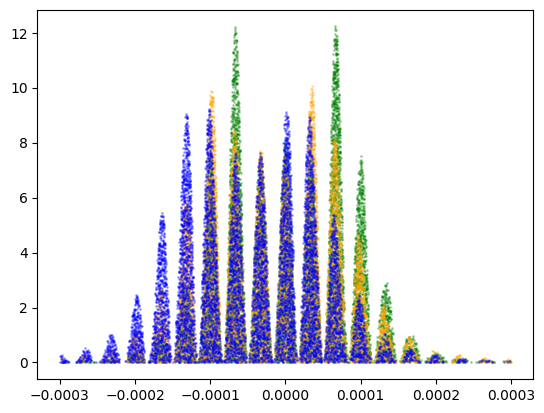

In [5]:
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2, alpha=.3)

parameters = {'baseline_len':10, 'theta_offaxis':2e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='orange', markersize=2, alpha=.3)

parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='blue', markersize=2, alpha=.3)
# plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
plt.show()

0.19175639267874092
0.189978627404417


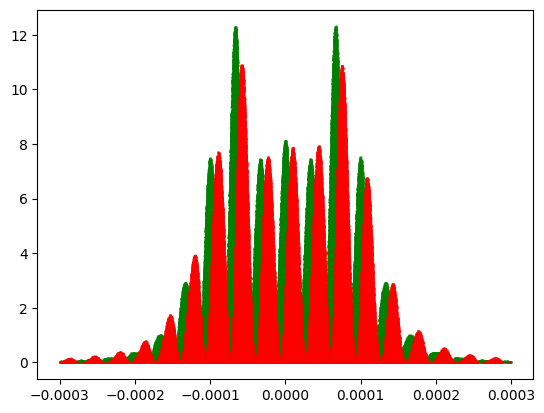

In [6]:
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(100000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2, alpha=.4)

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(100000, parameters, vary_P = True, delta_P_inp = 1e-5)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='red', markersize=2, alpha=.4)



# parameters = {'baseline_len':10, 'theta_offaxis':2e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

# accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters, vary_P = True)
# print(len(accepted_y)/len(rejected_y))
# plt.plot(accepted_y, accepted_I, '.', color='orange', markersize=2, alpha=.4)

# parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

# accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters, vary_P = True)
# print(len(accepted_y)/len(rejected_y))
# plt.plot(accepted_y, accepted_I, '.', color='blue', markersize=2, alpha=.4)
# plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
plt.show()

Expected Noise Power: 0.6
Total accepted no. of ph: 2000


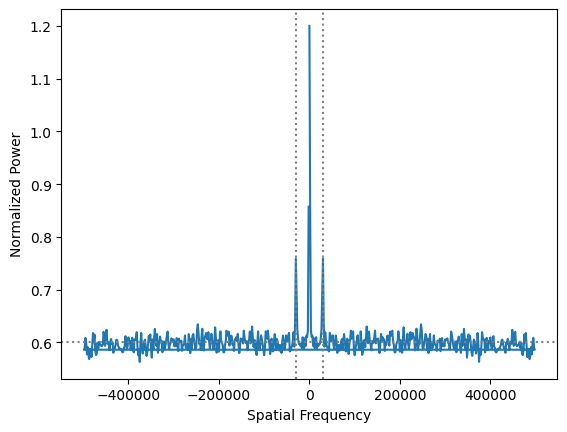

In [7]:
plt.close()
parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

yf_list = []
accepted_photons = []
n_exp = int(1e3)
n_ph_per_exp = 2
for i in range(n_exp):
    delta_P = np.random.uniform(size = 1) * 1e-2
    accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSamples(n_ph_per_exp, parameters, vary_P = True, ret_ph_count = True, delta_P_inp = delta_P)
    accepted_photons.append(n_ph)
    n_bins = 600
    spacing = (2 * 0.0003) / n_bins
    bins_y = np.linspace(-0.0003, -.0003 + spacing * n_bins, n_bins, endpoint=True)
    counts, edges = np.histogram(accepted_y, bins=bins_y)
    
    # plt.step(edges[:-1], counts/100)
    # plt.show()
    
    # if np.sum(counts>0):
    
    # Define Fourier Frequencies:
    N = len(edges) - 1 # Number of bins
    min_freq = 1/N
    max_freq = 1/2 * (1/N)
    
    # Take the Fourier Transform
    yf = scft.fft(counts)
    
    # Normalize
    # yf = 2 * n_bins * np.abs(yf)**2 / (np.sum(counts)**2)
    yf = np.abs(yf)**2
    yf_list.append(yf)
    
    # Define the corresponding frequencies
    xf = scft.fftfreq(N, edges[1]-edges[0])
# print(accepted_photons)
yf_list = np.array(yf_list)
sum_yf = np.sum(yf_list, axis=0)
tot_accepted_ph = np.sum(accepted_photons)
norm_yf = 2 * (n_bins / tot_accepted_ph**2) * sum_yf
P_noise = 2 * n_bins / tot_accepted_ph

val = np.argsort(sum_yf)[-4]-1
val_2 = 0

print('Expected Noise Power:', P_noise)
print('Total accepted no. of ph:', tot_accepted_ph)
plt.plot(xf, norm_yf)
# plt.plot(xf, sum_yf)
plt.axvline(30000, linestyle='dotted', color='grey')
plt.axvline(-30000, linestyle='dotted', color='grey')
plt.axhline(P_noise, linestyle='dotted', color='grey')
plt.ylabel('Normalized Power')
plt.xlabel('Spatial Frequency')
plt.savefig(f'NormalizedPowerSpectrum_{n_exp}Exp_{n_ph_per_exp}PhotonsPerExp.pdf', dpi=300)
plt.show()

Text(0, 0.5, 'Probability of Power(nu) > Power(noise)')

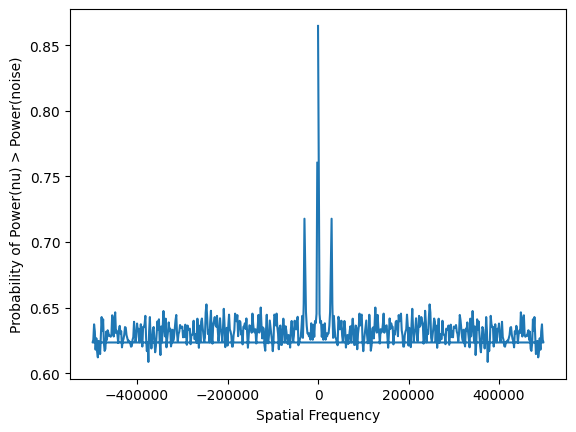

In [8]:
# %matplotlib widget
plt.close()
SNR = norm_yf/P_noise
prob = 1-np.exp(-SNR)
plt.plot(xf, prob)
plt.xlabel('Spatial Frequency')
plt.ylabel('Probability of Power(nu) > Power(noise)')
# plt.savefig(f'Probabiility{n_exp}Exp_{n_ph_per_exp}PhotonsPerExp.pdf', dpi=300)

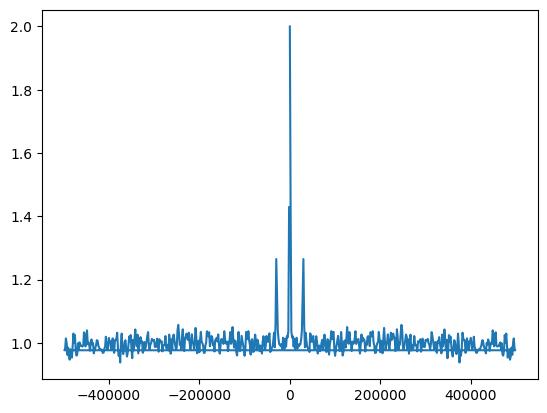

In [9]:
plt.close()
plt.plot(xf, SNR)
plt.show()

In [10]:
print(0.779/P_noise)

1.2983333333333333


In [10]:
plt.close()
parameters = {'baseline_len':1, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}
def wrapper(parameters = {'baseline_len':1, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 
                          'wavelength':10e-10}, ph_count_rate = 20, t_exp = 0.003, T_max = 1000, max_readout = 24, save_dir=''):

    # Define poisson count rate based on exposure time
    count_rate = t_exp * ph_count_rate

    # Ensure that the max readout rate is not exceeded
    if 1 / t_exp > max_readout:
        readout_rate = max_readout
    else:
        readout_rate = 1/t_exp

    # Calculate the required number of exposures to achieve integration time
    n_exp = int(T_max * readout_rate) # Number of exposures that correspond to the integration time
    
    yf_list = []
    accepted_photons = []
    print('Number of exposures to be taken:', n_exp)

    # Genarate number of photons that are recorded per exposure using a Poisson distribution
    n_ph_per_exp = scst.poisson.rvs(count_rate, size=n_exp)
    
    for i in range(n_exp):

        # Do the calculations only if we have >1 photons in the exposure
        if n_ph_per_exp[i] != 0:
            delta_P = np.random.uniform(size = 1) * 1e-2
            accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSamples(n_ph_per_exp[i], parameters, vary_P = True, ret_ph_count = True, delta_P_inp = delta_P)
            accepted_photons.append(n_ph)
            n_bins = 600
            spacing = (2 * 0.0003) / n_bins
            bins_y = np.linspace(-0.0003, -.0003 + spacing * n_bins, n_bins, endpoint=True)
            counts, edges = np.histogram(accepted_y, bins=bins_y)
            
            
            # Define Fourier Frequencies:
            N = len(edges) - 1 # Number of bins
            min_freq = 1/N
            max_freq = 1/2 * (1/N)
            # print(min_freq, max_freq)
            
            # Take the Fourier Transform
            yf = scft.fft(counts)
            
            # Normalize
            # yf = 2 * n_bins * np.abs(yf)**2 / (np.sum(counts)**2)
            yf = np.abs(yf)**2
            yf_list.append(yf)
            
            # Define the corresponding frequencies
            xf = scft.fftfreq(N, edges[1]-edges[0])
    
    yf_list = np.array(yf_list)
    sum_yf = np.sum(yf_list, axis=0)
    tot_accepted_ph = np.sum(accepted_photons)
    norm_yf = 2 * (n_bins / tot_accepted_ph**2) * sum_yf
    P_noise = 2 * n_bins / tot_accepted_ph
    
    val = np.argsort(sum_yf)[-4]-1
    val_2 = 0
    sigma = P_noise / np.sqrt(n_exp)
    
    one_sigma_int = P_noise + 1 * sigma
    two_sigma_int = P_noise + 2 * sigma
    three_sigma_int = P_noise + 3 * sigma
    
    plt.plot(xf, norm_yf)
    # plt.plot(xf, sum_yf)
    plt.axvline(30000, linestyle='dotted', color='grey')
    plt.axvline(-30000, linestyle='dotted', color='grey')
    plt.axhline(P_noise, linestyle='dotted', color='grey')
    plt.axhline(three_sigma_int, linestyle='dotted', color='grey')
    plt.axhline(two_sigma_int, linestyle='dotted', color='grey')
    plt.axhline(one_sigma_int, linestyle='dotted', color='grey')
    plt.ylabel('Normalized Power')
    plt.xlabel('Spatial Frequency')
    plt.savefig(f'{save_dir}NormalizedPowerSpectrum_run{run_num}_{t_exp}texp_{T_max}Tmax_{ph_count_rate}photoncountrate.png', dpi=300)
    # plt.show()
    # plt.hist(accepted_photons)
    # plt.show()

<h1>Sample Experimental Run</h1>

Number of exposures to be taken: 1920000


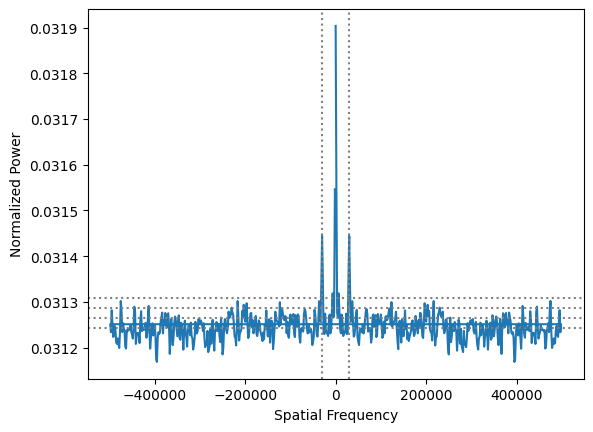

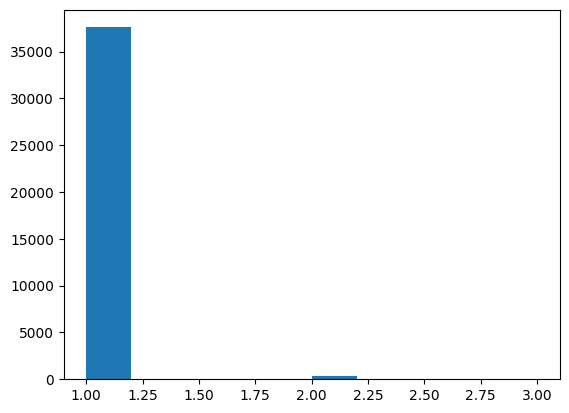

Number of exposures to be taken: 1920000


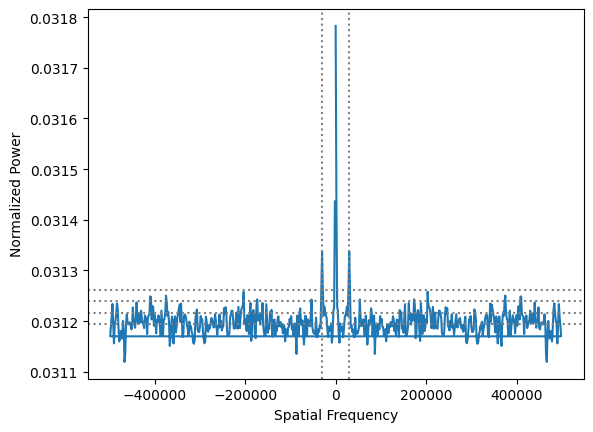

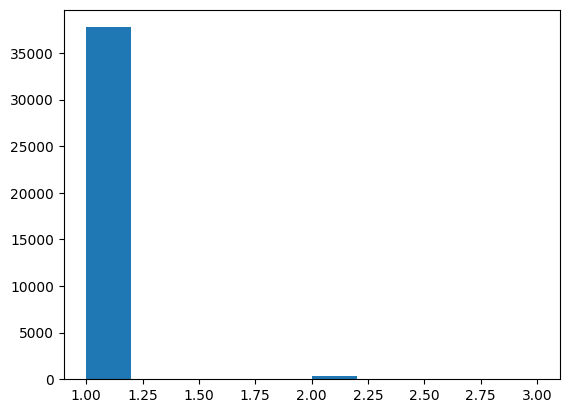

Number of exposures to be taken: 1920000


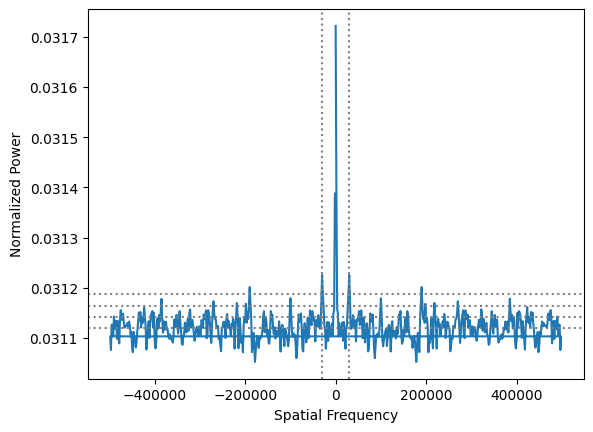

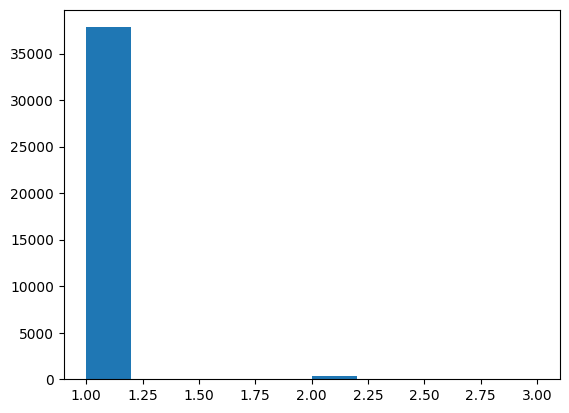

Number of exposures to be taken: 1920000


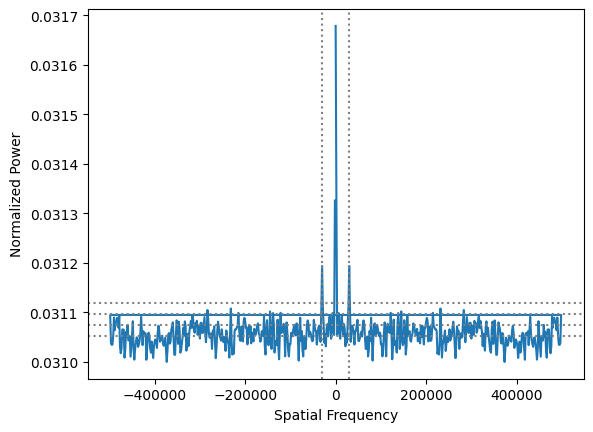

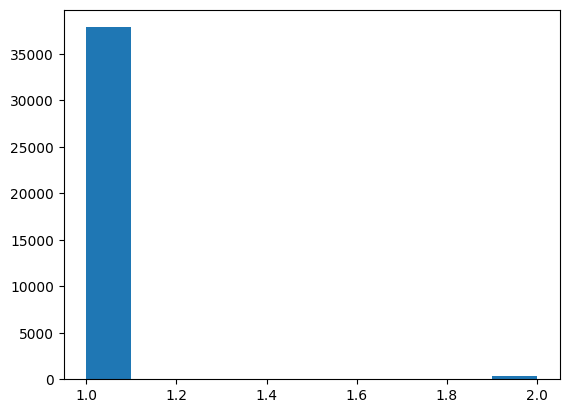

Number of exposures to be taken: 1920000


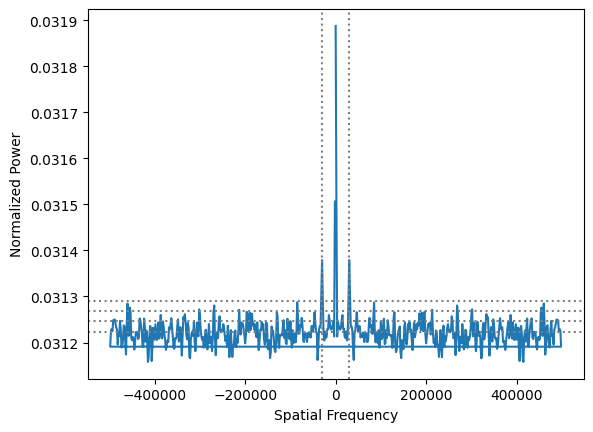

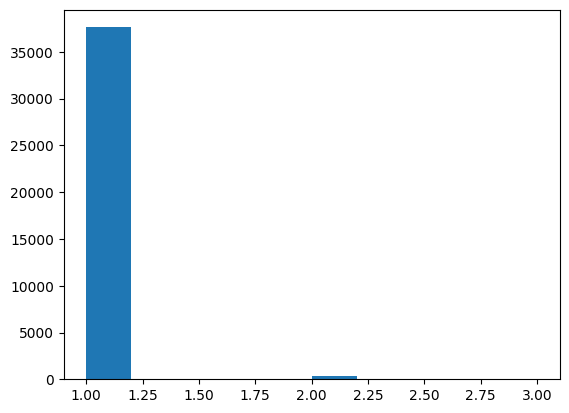

Number of exposures to be taken: 1920000


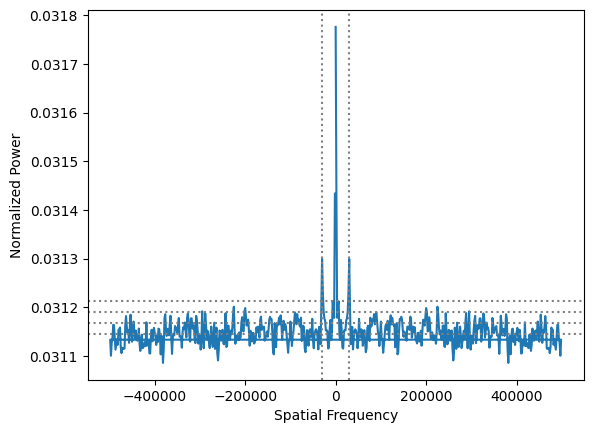

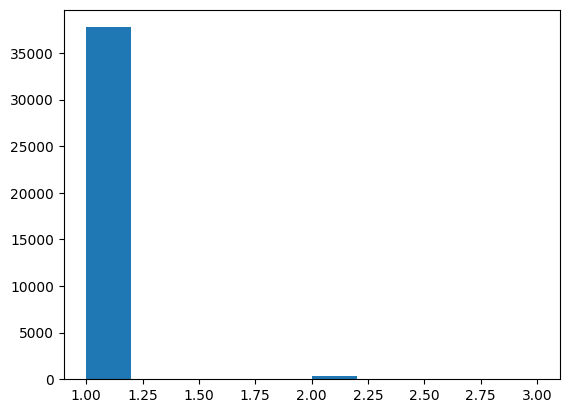

Number of exposures to be taken: 1920000


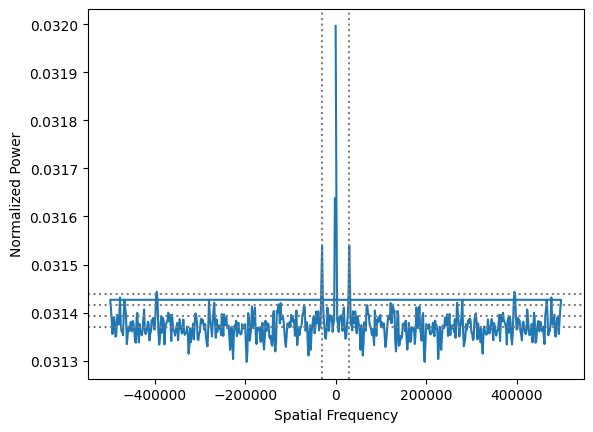

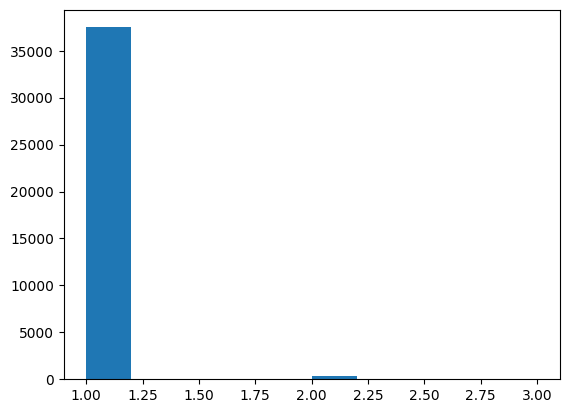

Number of exposures to be taken: 1920000


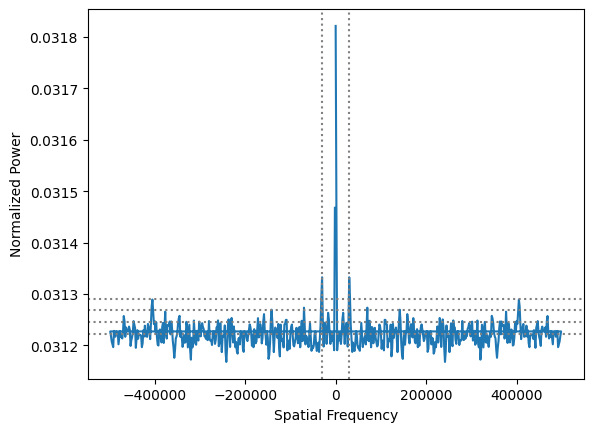

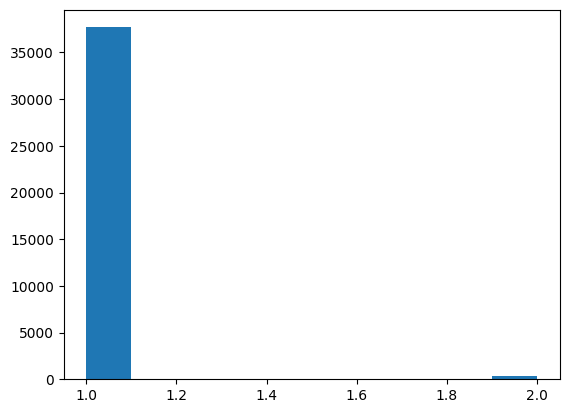

Number of exposures to be taken: 1920000


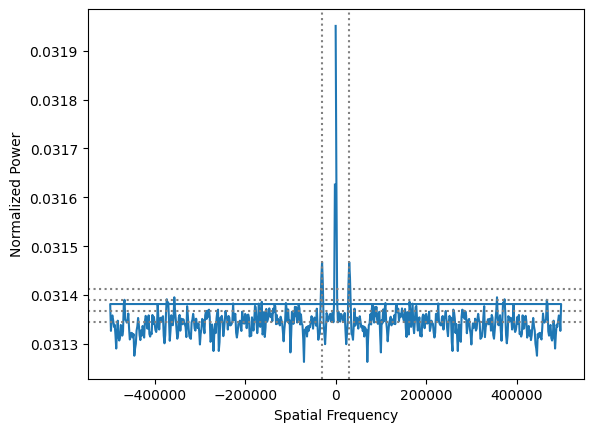

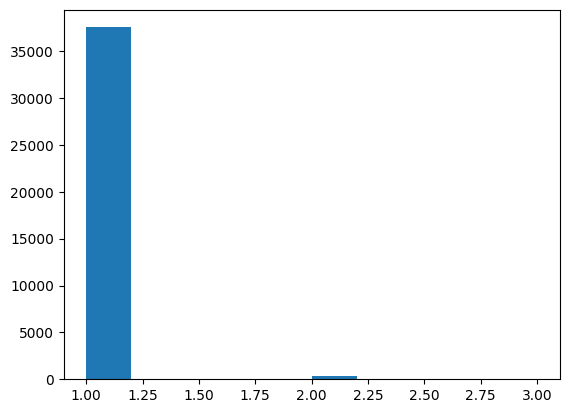

Number of exposures to be taken: 1920000


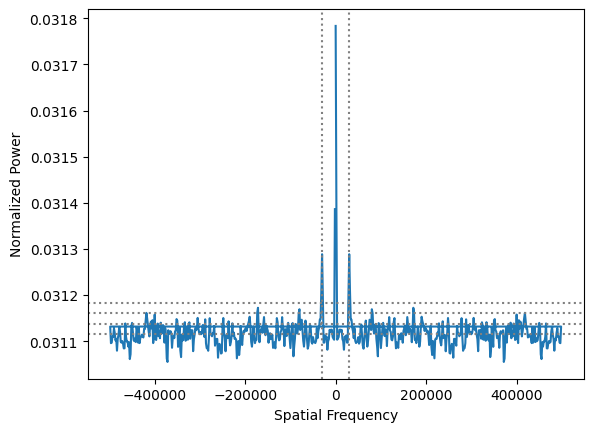

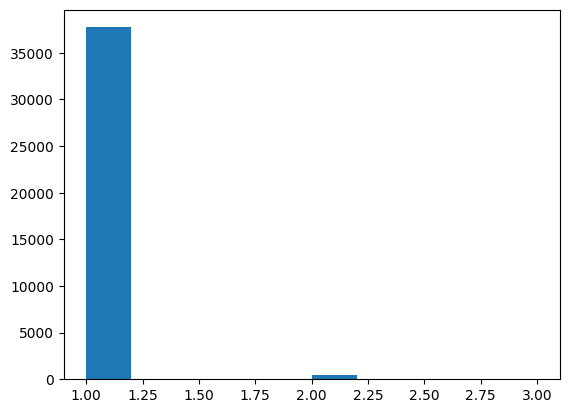

Number of exposures to be taken: 1920000


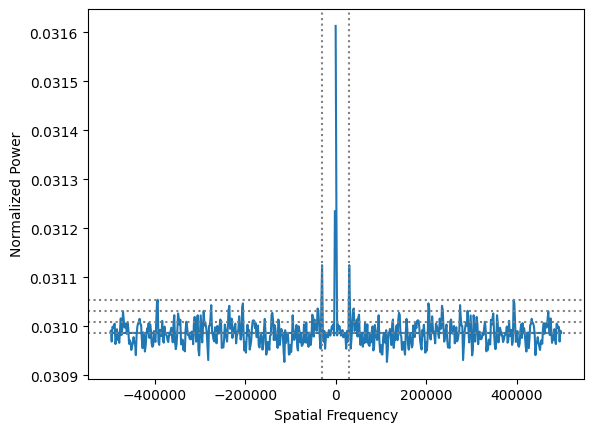

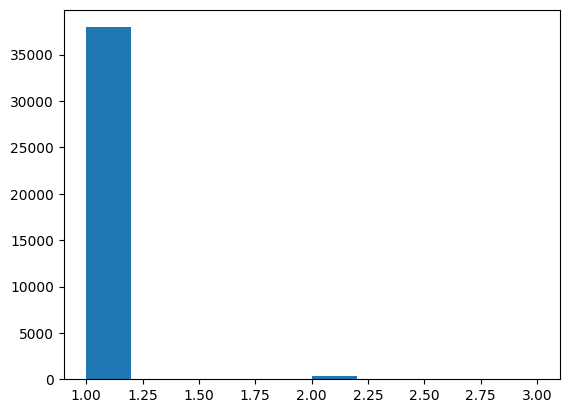

Number of exposures to be taken: 1920000


In [ ]:
# Define parameters for the setup
# All values are defined in SI units
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

# Define experimental parameters for a given run
ph_count_rate = 20 # Expected count rate in photons/s
t_exp = 0.001 # Time interval for one exposure in s
T_max = 80000 # Maximum integration time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)

save_dir='Results/Set 6/' # Directory to save results in

n_exp_runs = 20

run_num = 1

for j in range(n_exp_runs):
    plt.close()
    wrapper(parameters = parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, save_dir=save_dir)
    run_num += 1

## Converting to Probabilities
If we stack N periodgrams, we expect this to be distributed as a chi-squared distribution:
$$P \sim \chi^2_{2N}$$. Due to the normalization, this gets scaled as:
$$
P \sim \frac{\langle P \rangle}{2N}\chi^2_{2N}
$$
Due to this scaling, the variance of the distribution goes as:
$$
V[P] = {\left( \frac{\langle P \rangle}{2N}\right)}^2 4N
$$
$$
\sigma_P = \frac{\langle P \rangle}{\sqrt{N}}
$$
where 
$$
\langle P_{noise} \rangle = \frac{2 n_{pixels}}{n_{photons}}
$$
Hence, we can define $2,3-\sigma$ limits to our values (the $\chi^2$ distribution is essentially a normal distribution due to the central limit theorem)